In [1]:
%load_ext autoreload
%env TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler



env: TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets


2022-10-06 11:43:53.092489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paul/.virtualenvs/tfmetal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [2]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

2022-10-05 18:57:50.876127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-05 18:57:50.876968: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-05 18:57:50.877125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-10-05 18:57:50.882866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def normalize(x):
    return x/255

data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]

## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [4]:
%autoreload 2

data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]


x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=True)

2022-10-05 18:57:53.286256: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:

%autoreload 2

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)

79/79 [==============================] - 4s 25ms/step


Score visualization

40/40 [==============================] - 1s 22ms/step


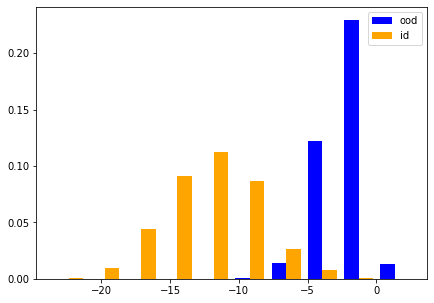

In [6]:
%autoreload 2

plt.figure(figsize=(7,5))

scores_id, scores_ood = oodmodel.score([x_id, x_ood])
plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [8]:
data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]
x_train = ds1["train"]


x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000), shuffle='True')

2022-10-05 18:58:34.304213: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
%autoreload 2
oodmodel = DKNN()
oodmodel.fit(model, x_train.take(10000))
scores = oodmodel.score(x_test)

2022-10-05 18:58:34.832541: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


40/40 [==============================] - 2s 38ms/step


2022-10-05 18:58:36.614291: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-05 18:58:37.290771: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-05 18:58:37.498685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

1/8 [==>...........................] - ETA: 3s

2022-10-05 18:58:37.884412: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-05 18:58:38.042173: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


8/8 [==============================] - 1s 25ms/step


Score visualization

2022-10-05 18:58:46.095162: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-10-05 18:58:51.252530: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 0s 22ms/step


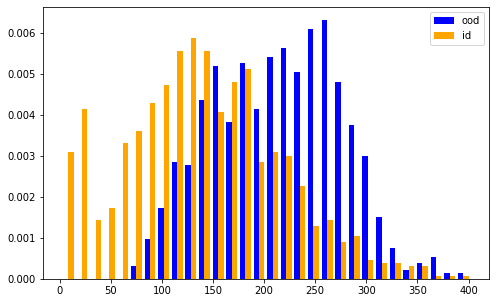

In [10]:
%autoreload 2
plt.figure(figsize=(8,5))


x_id, y_id = data_handler.convert_to_numpy(x_id)
x_ood, y_ood = data_handler.convert_to_numpy(x_ood)
scores_id, scores_ood = oodmodel.score([x_id[:1000], x_ood[:1000]])
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()